## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install sentence-transformers optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

In [ ]:
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
import optuna
from optuna.trial import TrialState
import torch
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
import torch.nn as nn
import torch.nn.functional as F
from transformers import get_linear_schedule_with_warmup
from sentence_transformers import SentenceTransformer, InputExample, losses
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay

## Data

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Классификатор негативных комментариев/Data/train.csv')
df_val = pd.read_csv('/content/drive/MyDrive/Классификатор негативных комментариев/Data/validation.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Классификатор негативных комментариев/Data/test.csv')

In [ ]:
df_train = df_train[df_train['class'] != 'figurative']
df_val = df_val[df_val['class'] != 'figurative']
df_test = df_test[df_test['class'] != 'figurative']

In [ ]:
print("Train set:")
print(df_train.shape)

print("\nValidation set:")
print(df_val.shape)

print("\nTest set:")
print(df_test.shape)

Train set:
(60166, 6)

Validation set:
(6017, 6)

Test set:
(6075, 6)


In [ ]:
train_counts = df_train['class'].value_counts()
val_counts = df_val['class'].value_counts()
test_counts = df_test['class'].value_counts()

combined_counts = pd.DataFrame({
    'train': train_counts,
    'val': val_counts,
    'test': test_counts
})

combined_counts

train   val  test
class                     
irony    20891  2089  2111
sarcasm  20680  2068  2105
regular  18595  1860  1859

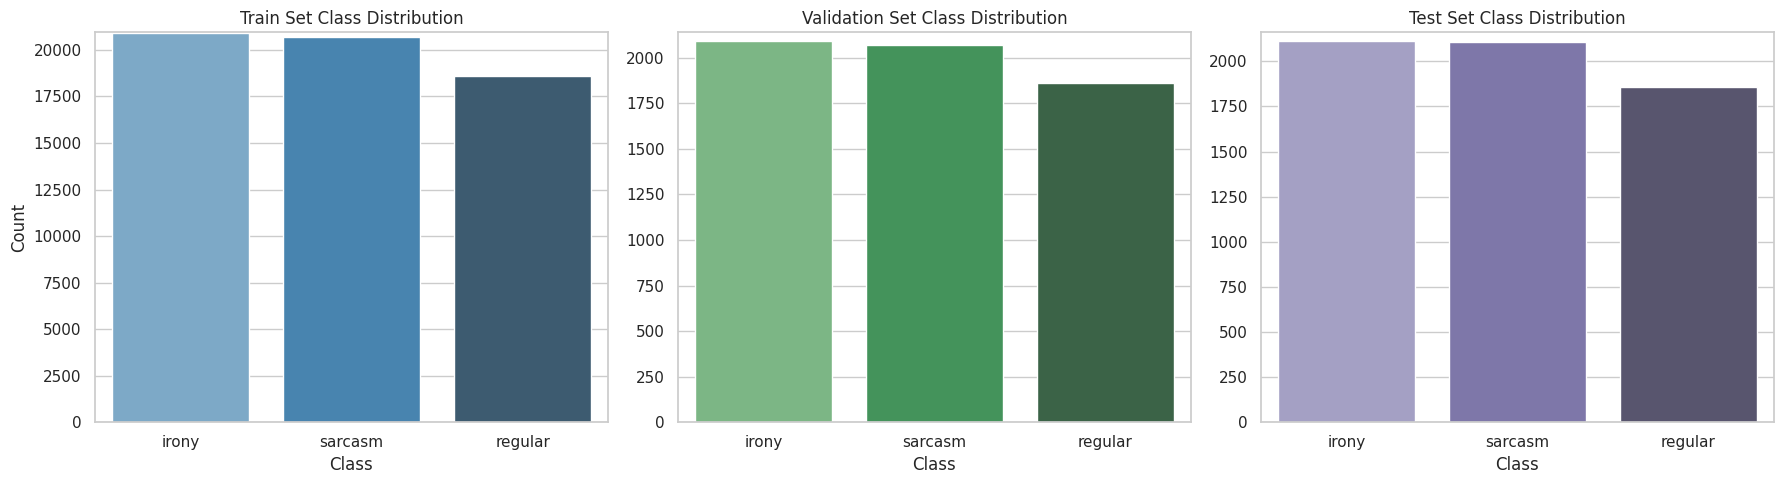

In [ ]:
reverse_class_mapping = {v: k for k, v in class_mapping.items()}

class_counts_train = df_train['class'].value_counts()
class_counts_val = df_val['class'].value_counts()
class_counts_test = df_test['class'].value_counts()

sns.set(style="whitegrid", palette="viridis")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# График для тренировочного набора
sns.barplot(x=[reverse_class_mapping[i] for i in class_counts_train.index],
            y=class_counts_train.values, ax=axes[0], palette="Blues_d")
axes[0].set_title('Train Set Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_ylim(0, max(class_counts_train.values) + 50)

# График для валидационного набора
sns.barplot(x=[reverse_class_mapping[i] for i in class_counts_val.index],
            y=class_counts_val.values, ax=axes[1], palette="Greens_d")
axes[1].set_title('Validation Set Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylim(0, max(class_counts_val.values) + 50)

# График для тестового набора
sns.barplot(x=[reverse_class_mapping[i] for i in class_counts_test.index],
            y=class_counts_test.values, ax=axes[2], palette="Purples_d")
axes[2].set_title('Test Set Class Distribution')
axes[2].set_xlabel('Class')
axes[2].set_ylim(0, max(class_counts_test.values) + 50)

plt.tight_layout()
plt.show()


В наборах данных с классовым дисбалансом модель может быть смещена в сторону преобладающего класса, поскольку она стремится минимизировать общую ошибку. Это может привести к снижению производительности в классе меньшинства, поскольку модель не научится эффективно распознавать его.

Присваивая более высокие значения классу меньшинства (в данном случае "regular" классу), функция потерь сильнее наказывает модель за неправильную классификацию экземпляров этого класса. Это побуждает модель уделять больше внимания классу меньшинства во время обучения.

Теперь мы собираемся попробовать этот подход.

### Implementing Class Weights

In [ ]:
class_mapping = {'regular': 0, 'irony': 1, 'sarcasm': 2}

In [ ]:
df_train['class'] = df_train['class'].map(class_mapping)
df_val['class'] = df_val['class'].map(class_mapping)
df_test['class'] = df_test['class'].map(class_mapping)

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df_train['class']), y=df_train['class'].values)
class_weights = torch.tensor(class_weights, dtype=torch.float)

Также заранее напишем функцию лосса, учитывающую веса для дальнейшего обучения.

In [ ]:
def weighted_loss(predictions, targets, weights):
    loss = F.cross_entropy(predictions, targets, weight=weights, reduction='none')
    return loss.mean()

#### Creating Embeddings

In [ ]:
base_model = SentenceTransformer('sentence-transformers/all-roberta-large-v1')

#Модель для fine-tuning
num_classes = len(class_mapping)
model = FineTunedSentenceTransformer(base_model, num_classes)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.68k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Модель `SentenceTransformer`, используемая в данном случае, уже обучена на большом количестве текстовых данных и может создавать качественные эмбеддинги для различных текстов. Однако, для улучшения производительности на конкретной задаче, такой как классификация твитов, модель может быть дообучена (fine-tuned) на специфических данных.

В данном случае, fine-tuning происходит до этапа энкодинга. Это означает, что предобученная модель адаптируется к новой задаче путем обучения на специфическом наборе данных (в данном случае, на твитах). На верхние слои предобученной модели добавляется линейный классификатор, который обучается на эмбеддингах, созданных моделью `SentenceTransformer`. Этот классификатор адаптируется к задаче классификации твитов.

In [ ]:
class FineTunedSentenceTransformer(nn.Module):
    def __init__(self, word_embedding_model, num_classes):
        super(FineTunedSentenceTransformer, self).__init__()
        self.word_embedding_model = word_embedding_model

        self.word_embedding_model.show_progress_bar = False

        example_input = ["It is tweet"]
        example_embedding = self.word_embedding_model.encode(example_input, convert_to_tensor=True)

        embedding_dimension = example_embedding.shape[0]

        self.classifier = nn.Linear(embedding_dimension, num_classes)

    def forward(self, input_ids):
        embeddings = self.word_embedding_model.encode(input_ids, convert_to_tensor=True, show_progress_bar=False)
        logits = self.classifier(embeddings)
        return logits

    def encode(self, texts, convert_to_tensor=False):
        """Embed sentences using the underlying SentenceTransformer model."""
        embeddings = []
        for text in tqdm(texts, desc="Encoding texts"):
            embedding = self.word_embedding_model.encode(text, convert_to_tensor=convert_to_tensor, show_progress_bar=False)
            embeddings.append(embedding)
        if convert_to_tensor:
            embeddings = torch.stack(embeddings)
        return embeddings

В процессе fine-tuning замораживаются (не обновляются) слои предобученной модели, чтобы сохранить уже извлеченные признаки.

In [ ]:
for param in model.word_embedding_model.parameters():
    param.requires_grad = False #Чтобы не обновляться

In [ ]:
train_embeddings = model.encode(df_train['tweets'].values.tolist(), convert_to_tensor=True)
val_embeddings = model.encode(df_val['tweets'].values.tolist(), convert_to_tensor=True)
test_embeddings = model.encode(df_test['tweets'].values.tolist(), convert_to_tensor=True)

Encoding texts:   0%|          | 0/60166 [00:00<?, ?it/s]

Encoding texts:   0%|          | 0/6017 [00:00<?, ?it/s]

Encoding texts:   0%|          | 0/6075 [00:00<?, ?it/s]

In [ ]:
y_train = torch.LongTensor(df_train['class'].values.tolist())
y_val = torch.LongTensor(df_val['class'].values.tolist())
y_test = torch.LongTensor(df_test['class'].values.tolist())

print(y_train.size(), y_val.size(), y_test.size())

torch.Size([60166]) torch.Size([6017]) torch.Size([6075])


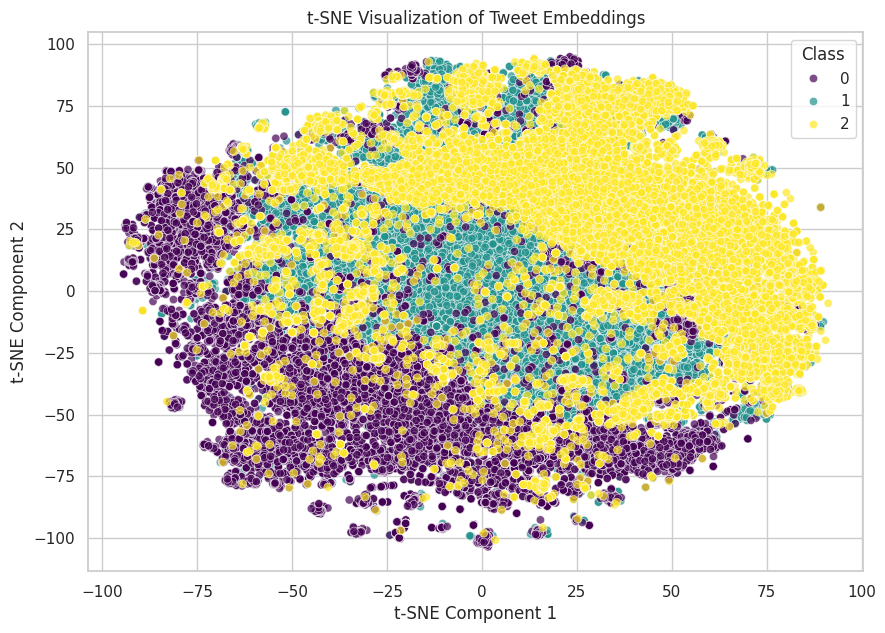

In [ ]:
from sklearn.manifold import TSNE

train_embeddings_cpu = train_embeddings.cpu().numpy()
y_train_cpu = y_train.cpu().numpy()

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(train_embeddings_cpu)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=y_train_cpu,
                palette='viridis', legend='full', alpha=0.7)
plt.title('t-SNE Visualization of Tweet Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Class', loc='upper right')
plt.show()


In [ ]:
import pickle

with open('/content/drive/MyDrive/Классификатор негативных комментариев/Data/train_embeddings.pkl', 'wb') as f:
    pickle.dump(train_embeddings, f)

with open('/content/drive/MyDrive/Классификатор негативных комментариев/Data/val_embeddings.pkl', 'wb') as f:
    pickle.dump(val_embeddings, f)

with open('/content/drive/MyDrive/Классификатор негативных комментариев/Data/test_embeddings.pkl', 'wb') as f:
    pickle.dump(test_embeddings, f)

## Model architecture

Класс `SBERTClassifier` — это нейронная сеть для классификации эмбеддингов, созданных моделью Sentence Transformer. Её архитектура включает:

1. **Batch Normalization**: Нормализует входные эмбеддинги для стабилизации обучения.

2. **Dropout**: Случайно отключает часть нейронов во время обучения для предотвращения переобучения. Значение данного параметра будет подбираться далее.

3. **Линейный слой**: Преобразует нормализованные эмбеддинги в логиты для каждого класса.

4. **ReLU**: Функция активации, вводящая нелинейность в модель.

Метод `forward` обрабатывает эмбеддинги, применяя нормализацию, dropout, линейное преобразование и активацию, возвращая логиты для классификации.

In [ ]:
class SBERTClassifier(nn.Module):
    def __init__(self, embedding_dim, num_labels, dropout_rate=0.3):
        super(SBERTClassifier, self).__init__()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn = nn.BatchNorm1d(embedding_dim)
        self.linear = nn.Linear(embedding_dim, num_labels)
        self.activation = nn.ReLU()

    def forward(self, embeddings):
        embeddings = self.bn(embeddings)
        embeddings = self.dropout(embeddings)
        logits = self.linear(embeddings)
        logits = self.activation(logits)
        return logits

Несмотря на свою простоту, архитектура `SBERTClassifier` обладает высокой эффективностью благодаря следующим аспектам:

1. **Использование предобученных эмбеддингов**: Модель опирается на качественные эмбеддинги, созданные Sentence Transformer, которые уже содержат богатую семантическую информацию. Это позволяет нашему классификатору сосредоточиться на извлечении специфичных для задачи признаков.

2. **Быстрое обучение**: За счет заморозки слоев предобученной модели, обучаются только слои классификатора, что значительно сокращает время и вычислительные ресурсы, необходимые для обучения.

3. **Регуляризация с помощью Dropout**: Использование Dropout помогает предотвратить переобучение, делая модель более устойчивой к шуму в данных и улучшая её обобщающую способность.

4. **Нормализация данных**: Batch Normalization стабилизирует процесс обучения, позволяя использовать более высокие скорости обучения и ускоряя сходимость модели.

In [ ]:
with open('/content/drive/MyDrive/Классификатор негативных комментариев/Data/train_embeddings.pkl', 'rb') as f:
    train_embeddings = pickle.load(f)

with open('/content/drive/MyDrive/Классификатор негативных комментариев/Data/val_embeddings.pkl', 'rb') as f:
    val_embeddings = pickle.load(f)

with open('/content/drive/MyDrive/Классификатор негативных комментариев/Data/test_embeddings.pkl', 'rb') as f:
    test_embeddings = pickle.load(f)

print(f'Train embeddings shape: {train_embeddings.shape}')
print(f'Validation embeddings shape: {val_embeddings.shape}')
print(f'Test embeddings shape: {test_embeddings.shape}')

Train embeddings shape: torch.Size([60166, 1024])
Validation embeddings shape: torch.Size([6017, 1024])
Test embeddings shape: torch.Size([6075, 1024])


In [ ]:
y_train = torch.LongTensor(df_train['class'].values.tolist())
y_val = torch.LongTensor(df_val['class'].values.tolist())
y_test = torch.LongTensor(df_test['class'].values.tolist())

print(y_train.size(), y_val.size(), y_test.size())

torch.Size([60166]) torch.Size([6017]) torch.Size([6075])


In [ ]:
BATCH_SIZE = 32

train_dataset = TensorDataset(train_embeddings, y_train)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

val_dataset = TensorDataset(val_embeddings, y_val)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_embeddings, y_test)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

## Hyperparameter tuning

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Описание эксперимента**

1. **Гиперпараметры**:
   - **`learning_rate`**: Логарифмически равномерно выбирается из диапазона от $$1 \times 10^{-6} \text{ до } 1 \times 10^{-2}.$$ Этот параметр определяет скорость обучения модели.
   - **`batch_size`**: Выбирается из заданного набора значений \([16, 32, 64, 128]\). Определяет количество примеров, обрабатываемых за один шаг обучения.
   - **`dropout_rate`**: Равномерно выбирается из диапазона от 0.0 до 0.7. Определяет долю нейронов, которые будут отключены для предотвращения переобучения.

2. **Создание и настройка модели**:
   - Инициализируется наша модель `SBERTClassifier` с заданными гиперпараметрами.
   - Оптимизатор `AdamW` используется для обновления весов модели с заданной скоростью обучения.
   - Планировщик `get_linear_schedule_with_warmup` управляет изменением скорости обучения в процессе тренировки.




**Цель эксперимента**

Цель эксперимента — минимизировать потерю на валидационном наборе данных, что соответствует нахождению наилучших гиперпараметров для модели. Optuna автоматически подбирает различные комбинации гиперпараметров и выбирает ту, которая дает наименьшую потерю, улучшая тем самым производительность модели.

In [ ]:
def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.7)
    num_epochs = 10

    model = SBERTClassifier(embedding_dim=train_embeddings.shape[1], num_labels=num_classes, dropout_rate=dropout_rate).to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_dataloader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    model.train()
    for epoch in range(num_epochs):
        for embeddings, labels in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
            embeddings, labels = embeddings.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = weighted_loss(outputs, labels, class_weights.to(device))
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

    model.eval()
    val_loss = 0
    correct_predictions = 0
    with torch.no_grad():
        for embeddings, labels in tqdm(val_dataloader, desc='Validation', leave=False):
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings)
            loss = weighted_loss(outputs, labels, class_weights.to(device))
            val_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = correct_predictions.double() / len(val_dataset)

    return avg_val_loss


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, timeout=1200)

[I 2025-03-22 18:32:13,876] A new study created in memory with name: no-name-aaba866b-26b1-4518-ac94-d9c787142f58


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:32:59,161] Trial 0 finished with value: 0.01754250216462816 and parameters: {'learning_rate': 0.006950841027129067, 'batch_size': 64, 'dropout_rate': 0.414800271786837}. Best is trial 0 with value: 0.01754250216462816.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:33:44,756] Trial 1 finished with value: 0.008653718803742098 and parameters: {'learning_rate': 0.0023349870382054325, 'batch_size': 32, 'dropout_rate': 0.12222329727413862}. Best is trial 1 with value: 0.008653718803742098.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:34:30,084] Trial 2 finished with value: 0.01918086767983325 and parameters: {'learning_rate': 0.009629647903495629, 'batch_size': 32, 'dropout_rate': 0.3562570468850928}. Best is trial 1 with value: 0.008653718803742098.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:35:16,261] Trial 3 finished with value: 0.016948181389818188 and parameters: {'learning_rate': 0.0016429704076460145, 'batch_size': 128, 'dropout_rate': 0.47418645374680674}. Best is trial 1 with value: 0.008653718803742098.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:36:02,070] Trial 4 finished with value: 0.02206042801860166 and parameters: {'learning_rate': 8.752504301140692e-05, 'batch_size': 32, 'dropout_rate': 0.4967771032762753}. Best is trial 1 with value: 0.008653718803742098.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:36:48,605] Trial 5 finished with value: 0.02152511571830714 and parameters: {'learning_rate': 0.0006889086190864109, 'batch_size': 32, 'dropout_rate': 0.6148239039480792}. Best is trial 1 with value: 0.008653718803742098.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:37:35,214] Trial 6 finished with value: 0.006942044990097579 and parameters: {'learning_rate': 0.0015237505185971283, 'batch_size': 16, 'dropout_rate': 0.08560191641762732}. Best is trial 6 with value: 0.006942044990097579.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:38:22,136] Trial 7 finished with value: 0.09278566318209328 and parameters: {'learning_rate': 6.504811960029984e-06, 'batch_size': 128, 'dropout_rate': 0.358666261771906}. Best is trial 6 with value: 0.006942044990097579.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:39:09,083] Trial 8 finished with value: 0.025416878269073784 and parameters: {'learning_rate': 0.00558582520278386, 'batch_size': 64, 'dropout_rate': 0.6246782417665241}. Best is trial 6 with value: 0.006942044990097579.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:39:55,798] Trial 9 finished with value: 0.030160955461892795 and parameters: {'learning_rate': 3.228894279899152e-05, 'batch_size': 64, 'dropout_rate': 0.4858806046555542}. Best is trial 6 with value: 0.006942044990097579.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:40:42,984] Trial 10 finished with value: 0.46619858139406434 and parameters: {'learning_rate': 1.361120046733833e-06, 'batch_size': 16, 'dropout_rate': 0.03635478587307245}. Best is trial 6 with value: 0.006942044990097579.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:41:29,738] Trial 11 finished with value: 0.009200561191278813 and parameters: {'learning_rate': 0.0003577269245443956, 'batch_size': 16, 'dropout_rate': 0.09835112898107543}. Best is trial 6 with value: 0.006942044990097579.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:42:17,522] Trial 12 finished with value: 0.011847606164082732 and parameters: {'learning_rate': 0.0014370761489381596, 'batch_size': 16, 'dropout_rate': 0.19987651965146536}. Best is trial 6 with value: 0.006942044990097579.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:43:04,231] Trial 13 finished with value: 0.012517095274517642 and parameters: {'learning_rate': 0.00021082032398301348, 'batch_size': 16, 'dropout_rate': 0.2028152403263551}. Best is trial 6 with value: 0.006942044990097579.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:43:51,961] Trial 14 finished with value: 0.008714301401524276 and parameters: {'learning_rate': 0.0019520552217286622, 'batch_size': 32, 'dropout_rate': 0.19080356734559722}. Best is trial 6 with value: 0.006942044990097579.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:44:39,231] Trial 15 finished with value: 0.021630021588809358 and parameters: {'learning_rate': 3.831587125250436e-05, 'batch_size': 16, 'dropout_rate': 0.014714823321499468}. Best is trial 6 with value: 0.006942044990097579.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:45:27,376] Trial 16 finished with value: 0.010247576743791549 and parameters: {'learning_rate': 0.0006067578778626792, 'batch_size': 32, 'dropout_rate': 0.11593728628424463}. Best is trial 6 with value: 0.006942044990097579.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:46:15,356] Trial 17 finished with value: 0.011872957801797961 and parameters: {'learning_rate': 0.003156269397586045, 'batch_size': 128, 'dropout_rate': 0.2706995635484842}. Best is trial 6 with value: 0.006942044990097579.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:47:03,121] Trial 18 finished with value: 0.013508547894311069 and parameters: {'learning_rate': 0.00014842617386984924, 'batch_size': 32, 'dropout_rate': 0.10911958531750351}. Best is trial 6 with value: 0.006942044990097579.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:47:51,079] Trial 19 finished with value: 0.010496926202413595 and parameters: {'learning_rate': 0.0008627192109540371, 'batch_size': 16, 'dropout_rate': 0.26665476591015436}. Best is trial 6 with value: 0.006942044990097579.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:48:38,538] Trial 20 finished with value: 0.013126953167993477 and parameters: {'learning_rate': 0.0032366432750546878, 'batch_size': 16, 'dropout_rate': 0.2859466833809189}. Best is trial 6 with value: 0.006942044990097579.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:49:26,647] Trial 21 finished with value: 0.009911186906931838 and parameters: {'learning_rate': 0.001965606767057084, 'batch_size': 32, 'dropout_rate': 0.1586814808308069}. Best is trial 6 with value: 0.006942044990097579.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:50:14,281] Trial 22 finished with value: 0.009008480032900393 and parameters: {'learning_rate': 0.00032120732727784496, 'batch_size': 32, 'dropout_rate': 0.0554462602841852}. Best is trial 6 with value: 0.006942044990097579.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:51:02,458] Trial 23 finished with value: 0.010549850087192112 and parameters: {'learning_rate': 0.0023180318480641665, 'batch_size': 32, 'dropout_rate': 0.1857265463730759}. Best is trial 6 with value: 0.006942044990097579.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:51:50,571] Trial 24 finished with value: 0.007922386744459942 and parameters: {'learning_rate': 0.004434916189494026, 'batch_size': 32, 'dropout_rate': 0.08350698811994628}. Best is trial 6 with value: 0.006942044990097579.


Epoch 1/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1881 [00:00<?, ?it/s]

Validation:   0%|          | 0/189 [00:00<?, ?it/s]

[I 2025-03-22 18:52:38,651] Trial 25 finished with value: 0.005481669543921268 and parameters: {'learning_rate': 0.0037135991420613316, 'batch_size': 32, 'dropout_rate': 0.010231588895909471}. Best is trial 25 with value: 0.005481669543921268.


In [ ]:
trial = study.best_trial
print('Best Objective Value: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Best Objective Value: 0.005481669543921268
Best hyperparameters: {'learning_rate': 0.0037135991420613316, 'batch_size': 32, 'dropout_rate': 0.010231588895909471}


## Training

In [ ]:
best_params = trial.params

best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']
best_dropout_rate = best_params['dropout_rate']

In [ ]:
model = SBERTClassifier(embedding_dim=train_embeddings.shape[1], num_labels=num_classes, dropout_rate=best_dropout_rate).to(device)
optimizer = AdamW(model.parameters(), lr=best_learning_rate)
total_steps = len(train_dataloader) * 100  # 100 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

Модель обучается в течение 100 эпох, проходя через тренировочные данные и обновляя веса для минимизации потерь. После каждой эпохи оценивается на валидационном наборе, и если потеря не улучшается в течение 10 эпох, обучение прекращается (early stopping). Мы отслеживаем потери и точность для анализа производительности модели.

In [ ]:
train_loss_per_epoch = []
val_loss_per_epoch = []
train_accuracy_per_epoch = []
val_accuracy_per_epoch = []

# Early stopping
patience = 10
min_delta = 0.001
best_loss = np.inf
patience_counter = 0

# Training loop
num_epochs = 100
model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_correct_predictions = 0
    for embeddings, labels in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
        embeddings, labels = embeddings.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = weighted_loss(outputs, labels, class_weights.to(device))
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        epoch_train_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        epoch_correct_predictions += torch.sum(preds == labels)

    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_accuracy = epoch_correct_predictions.double() / len(train_dataset)

    train_loss_per_epoch.append(avg_train_loss)
    train_accuracy_per_epoch.append(train_accuracy.item())

    # Evaluation loop
    model.eval()
    val_loss = 0
    correct_predictions = 0
    with torch.no_grad():
        for embeddings, labels in val_dataloader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings)
            loss = weighted_loss(outputs, labels, class_weights.to(device))
            val_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = correct_predictions.double() / len(val_dataset)

    val_loss_per_epoch.append(avg_val_loss)
    val_accuracy_per_epoch.append(val_accuracy.item())

    print(f'Epoch {epoch + 1}/{num_epochs}: Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {avg_val_loss}, Val Accuracy: {val_accuracy}')

    # Early stopping check
    if best_loss - avg_val_loss > min_delta:
        best_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs.')
        break

Epoch 1/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 1/100: Train Loss: 0.05949400409971807, Train Accuracy: 0.9837117308779045, Val Loss: 0.018905370567718547, Val Accuracy: 0.9961774970915739


Epoch 2/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 2/100: Train Loss: 0.027498733381810005, Train Accuracy: 0.9932187614267195, Val Loss: 0.019141855923976436, Val Accuracy: 0.9945155393053017


Epoch 3/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 3/100: Train Loss: 0.024632422528533676, Train Accuracy: 0.9939168301033807, Val Loss: 0.014704014354259292, Val Accuracy: 0.9973408675419644


Epoch 4/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 4/100: Train Loss: 0.021509292953251675, Train Accuracy: 0.9948309676561514, Val Loss: 0.017201069156129876, Val Accuracy: 0.9956789097556922


Epoch 5/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 5/100: Train Loss: 0.019235121161066356, Train Accuracy: 0.9947478642422631, Val Loss: 0.024784610421561774, Val Accuracy: 0.99401695196942


Epoch 6/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 6/100: Train Loss: 0.017444706114642473, Train Accuracy: 0.9957284845261444, Val Loss: 0.010078283014962636, Val Accuracy: 0.9976732590992189


Epoch 7/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 7/100: Train Loss: 0.015857929807857753, Train Accuracy: 0.9956287604294785, Val Loss: 0.013669319448943782, Val Accuracy: 0.9956789097556922


Epoch 8/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 8/100: Train Loss: 0.015721767065580716, Train Accuracy: 0.9958780706711432, Val Loss: 0.009896051368310848, Val Accuracy: 0.9973408675419644


Epoch 9/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 9/100: Train Loss: 0.014385678771171632, Train Accuracy: 0.9958614499883656, Val Loss: 0.015982984027122227, Val Accuracy: 0.9941831477480472


Epoch 10/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 10/100: Train Loss: 0.015108101451861198, Train Accuracy: 0.995745105208922, Val Loss: 0.010277055589789575, Val Accuracy: 0.9973408675419644


Epoch 11/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 11/100: Train Loss: 0.013984615976915025, Train Accuracy: 0.9959445534022539, Val Loss: 0.008866545564949374, Val Accuracy: 0.9980056506564733


Epoch 12/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 12/100: Train Loss: 0.013026011993428004, Train Accuracy: 0.9963268291061398, Val Loss: 0.007419145028432458, Val Accuracy: 0.9978394548778461


Epoch 13/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 13/100: Train Loss: 0.012825413870060268, Train Accuracy: 0.9962603463750291, Val Loss: 0.012855051046580574, Val Accuracy: 0.99700847598471


Epoch 14/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 14/100: Train Loss: 0.012210549393894007, Train Accuracy: 0.9963766911544727, Val Loss: 0.00923769708748899, Val Accuracy: 0.9978394548778461


Epoch 15/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 15/100: Train Loss: 0.013668930180363909, Train Accuracy: 0.996077518864475, Val Loss: 0.006933268460708857, Val Accuracy: 0.9983380422137278


Epoch 16/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 16/100: Train Loss: 0.011425773439291647, Train Accuracy: 0.9966592427616927, Val Loss: 0.008947692910211236, Val Accuracy: 0.9973408675419644


Epoch 17/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 17/100: Train Loss: 0.011372436755870519, Train Accuracy: 0.9964930359339162, Val Loss: 0.009507108923465558, Val Accuracy: 0.9973408675419644


Epoch 18/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 18/100: Train Loss: 0.011381006846720729, Train Accuracy: 0.9965761393478044, Val Loss: 0.006410611613317553, Val Accuracy: 0.9983380422137278


Epoch 19/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 19/100: Train Loss: 0.01042323677746611, Train Accuracy: 0.9965927600305821, Val Loss: 0.012206931691921863, Val Accuracy: 0.99700847598471


Epoch 20/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 20/100: Train Loss: 0.010824121254639881, Train Accuracy: 0.9966260013961374, Val Loss: 0.0071372405462693436, Val Accuracy: 0.9983380422137278


Epoch 21/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 21/100: Train Loss: 0.010902186112325178, Train Accuracy: 0.9966592427616927, Val Loss: 0.006549630348811609, Val Accuracy: 0.9986704337709822


Epoch 22/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 22/100: Train Loss: 0.0105391497083916, Train Accuracy: 0.996409932520028, Val Loss: 0.007385490245889104, Val Accuracy: 0.9978394548778461


Epoch 23/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 23/100: Train Loss: 0.009341734035063361, Train Accuracy: 0.9970747598311339, Val Loss: 0.012520003360986935, Val Accuracy: 0.9961774970915739


Epoch 24/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 24/100: Train Loss: 0.009946524198012282, Train Accuracy: 0.9968088289066915, Val Loss: 0.009475574536254866, Val Accuracy: 0.9971746717633372


Epoch 25/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 25/100: Train Loss: 0.01051200063334403, Train Accuracy: 0.9966592427616927, Val Loss: 0.006955469890142142, Val Accuracy: 0.9981718464351006


Epoch 26/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 26/100: Train Loss: 0.009334234213370908, Train Accuracy: 0.9970415184655786, Val Loss: 0.005900680104248211, Val Accuracy: 0.9980056506564733


Epoch 27/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 27/100: Train Loss: 0.010123772263168341, Train Accuracy: 0.9967922082239139, Val Loss: 0.010621303679765237, Val Accuracy: 0.9968422802060828


Epoch 28/100:   0%|          | 0/1881 [00:00<?, ?it/s]

Epoch 28/100: Train Loss: 0.008921555580982222, Train Accuracy: 0.9973406907555763, Val Loss: 0.006978757298087755, Val Accuracy: 0.9980056506564733
Early stopping triggered after 28 epochs.


### Visualisation

<Figure size 1200x600 with 0 Axes>

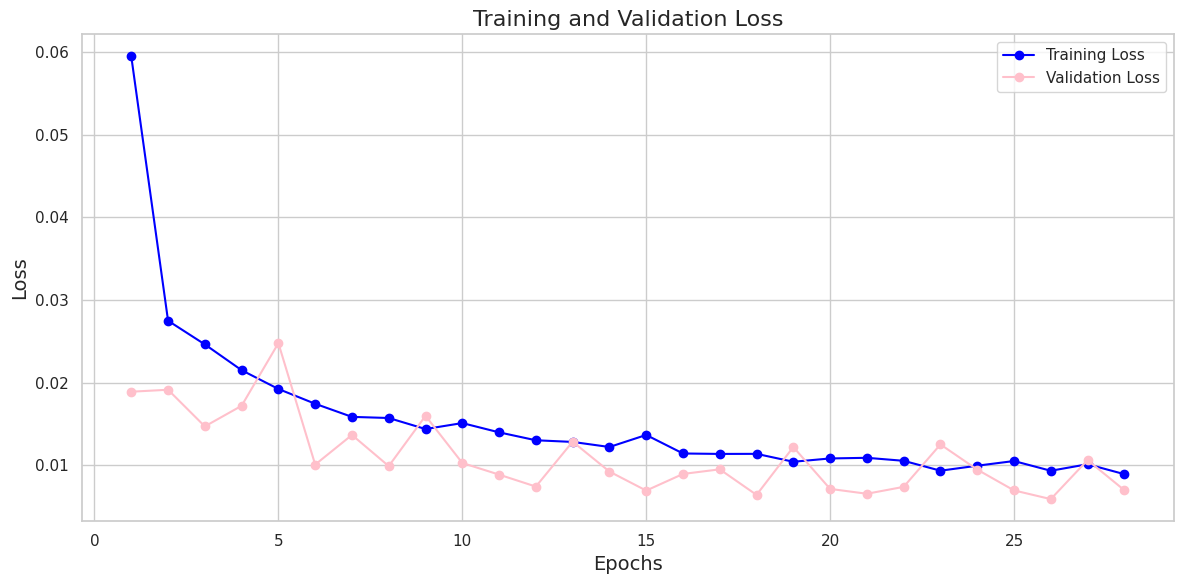

In [ ]:
sns.set(style="whitegrid")

epochs = range(1, 28 + 1)

plt.figure(figsize=(12, 6))

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_per_epoch, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss_per_epoch, label='Validation Loss', color='pink', marker='o')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.tick_params(axis='x')
plt.tick_params(axis='y')
plt.tight_layout()
plt.show()

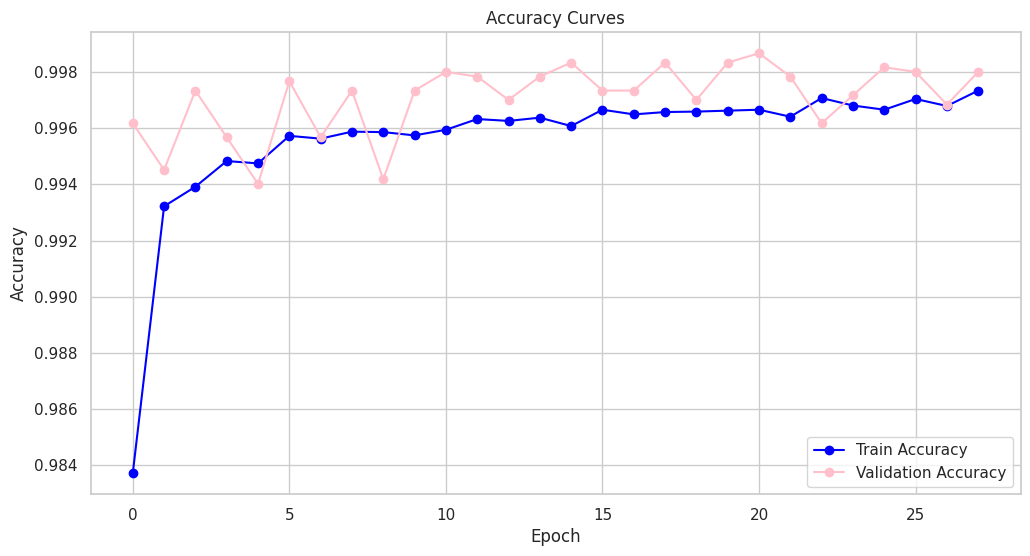

In [ ]:
sns.set(style="whitegrid")

epochs = range(1, 28 + 1)

plt.figure(figsize=(12, 6))
plt.plot(train_accuracy_per_epoch, label='Train Accuracy', color='blue', marker='o')
plt.plot(val_accuracy_per_epoch, label='Validation Accuracy', color='pink', marker='o')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Analysis of Validation

In [ ]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for embeddings, labels in val_dataloader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        outputs = model(embeddings)
        _, preds = torch.max(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

report = classification_report(y_true, y_pred, target_names=class_mapping.keys())
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     regular       1.00      1.00      1.00      1860
       irony       1.00      1.00      1.00      2089
     sarcasm       1.00      1.00      1.00      2068

    accuracy                           1.00      6017
   macro avg       1.00      1.00      1.00      6017
weighted avg       1.00      1.00      1.00      6017



вау.

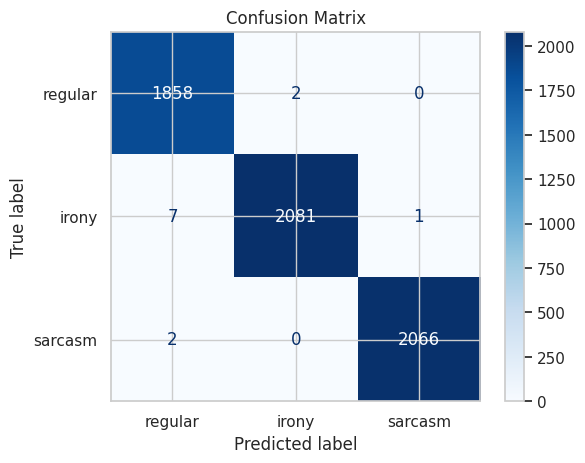

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_mapping.keys())

disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

Class regular ROC AUC score: 1.00
Class irony ROC AUC score: 1.00
Class sarcasm ROC AUC score: 1.00


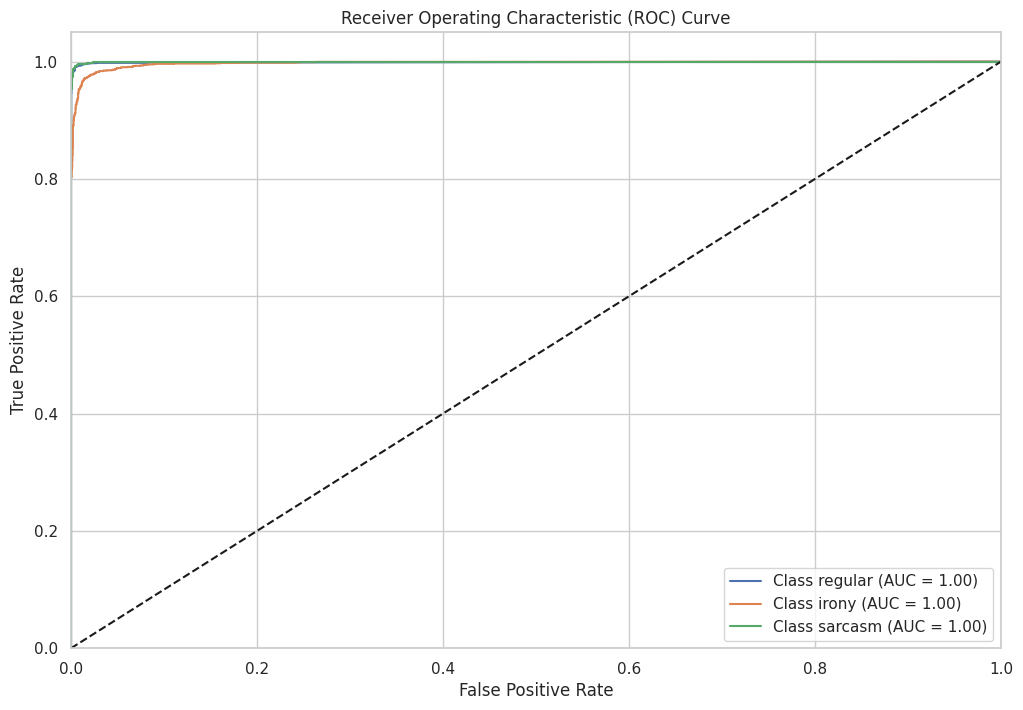

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

y_true_bin = label_binarize(y_true, classes=list(class_mapping.values()))
y_score = []

model.eval()
with torch.no_grad():
    for embeddings, labels in val_dataloader:
        embeddings = embeddings.to(device)
        outputs = model(embeddings)
        y_score.append(outputs.cpu().numpy())

y_score = np.concatenate(y_score, axis=0)

roc_auc = {}
for class_label, class_index in class_mapping.items():
    roc_auc[class_label] = roc_auc_score(y_true_bin[:, class_index], y_score[:, class_index])
    print(f'Class {class_label} ROC AUC score: {roc_auc[class_label]:.2f}')

plt.figure(figsize=(12, 8))
for class_label, class_index in class_mapping.items():
    fpr, tpr, _ = roc_curve(y_true_bin[:, class_index], y_score[:, class_index])
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc[class_label]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
class_mapping = {'regular': 0, 'irony': 1, 'sarcasm': 2}
reverse_class_mapping = {v: k for k, v in class_mapping.items()}

original_texts_val = df_val['tweets'].tolist()

misclassified_samples_val = []

model.eval()
with torch.no_grad():
    for batch_idx, (embeddings, labels) in enumerate(val_dataloader):
        embeddings, labels = embeddings.to(device), labels.to(device)
        outputs = model(embeddings)
        _, preds = torch.max(outputs, dim=1)

        for i in range(len(labels)):
            true_label = labels[i].item()
            predicted_label = preds[i].item()
            if true_label != predicted_label:
                original_index = batch_idx * val_dataloader.batch_size + i
                text = original_texts_val[original_index]
                misclassified_samples_val.append({
                    'text': text,
                    'true_label': reverse_class_mapping[true_label],
                    'predicted_label': reverse_class_mapping[predicted_label]
                })

for sample in misclassified_samples_val:
    print(f"Text: {sample['text']}")
    print(f"True Class: {sample['true_label']}")
    print(f"Predicted Class: {sample['predicted_label']}")
    print("-" * 50)


Text: To 86 is to kill. Ru486, the abortion drug just approved in Canada. ARE YOU FOR 86? Hmmm. #abortion #medicine #irony #moral #contraception
True Class: irony
Predicted Class: regular
--------------------------------------------------
Text: Sarcasm at work can increase creativity http://t.co/kABzDdNoDG #irony #communication
True Class: irony
Predicted Class: sarcasm
--------------------------------------------------
Text: Funny moments, clown version. #fun #funny #ironic #best #wig #clown #happy #smile #enjoy #color #blue… https://t.co/ICuvcUzkEC
True Class: irony
Predicted Class: regular
--------------------------------------------------
Text: A money launderer invited for a lecture. Glad to see that our institutions are becoming better. #Irony  #ShameOnKarachiUniversity
True Class: irony
Predicted Class: regular
--------------------------------------------------
Text: #BanMassMurdererIndiaFromUN India mentions itself as the most peace loving country but killing civilians across t

**Вывод об ошибках модели**

Несмотря на высокие показатели точности на валидационном наборе, модель допускает ошибки в классификации некоторых твитов. Это нормально, так как даже лучшие модели могут ошибаться из-за сложности и субъективности языка, особенно в случае сарказма и иронии. Важно, что общие метрики (precision, recall, f1-score) остаются на высоком уровне, что свидетельствует о хорошей производительности модели в целом.

Перейдем к анализу предсказаний на тестовых данных.

## Prediction

### Analysis of Test

In [ ]:
y_true = []
y_pred = []

model.eval()

with torch.no_grad():
    for embeddings, labels in test_dataloader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        outputs = model(embeddings)
        _, preds = torch.max(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

In [ ]:
report = classification_report(y_true, y_pred, target_names=class_mapping.keys())
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     regular       0.99      1.00      0.99      1859
       irony       1.00      0.99      0.99      2111
     sarcasm       1.00      1.00      1.00      2105

    accuracy                           1.00      6075
   macro avg       1.00      1.00      1.00      6075
weighted avg       1.00      1.00      1.00      6075



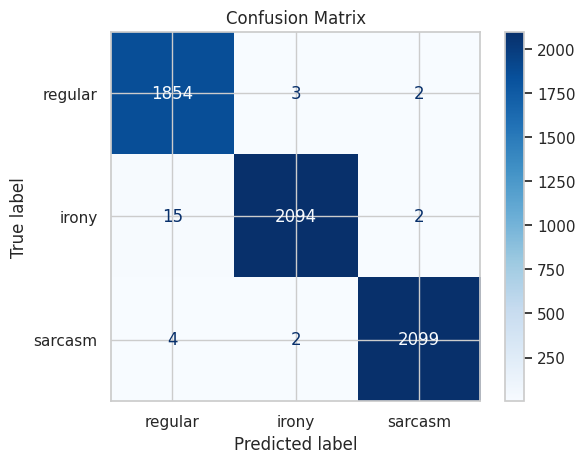

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_mapping.keys())

disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

Class regular ROC AUC score: 1.00
Class irony ROC AUC score: 1.00
Class sarcasm ROC AUC score: 1.00


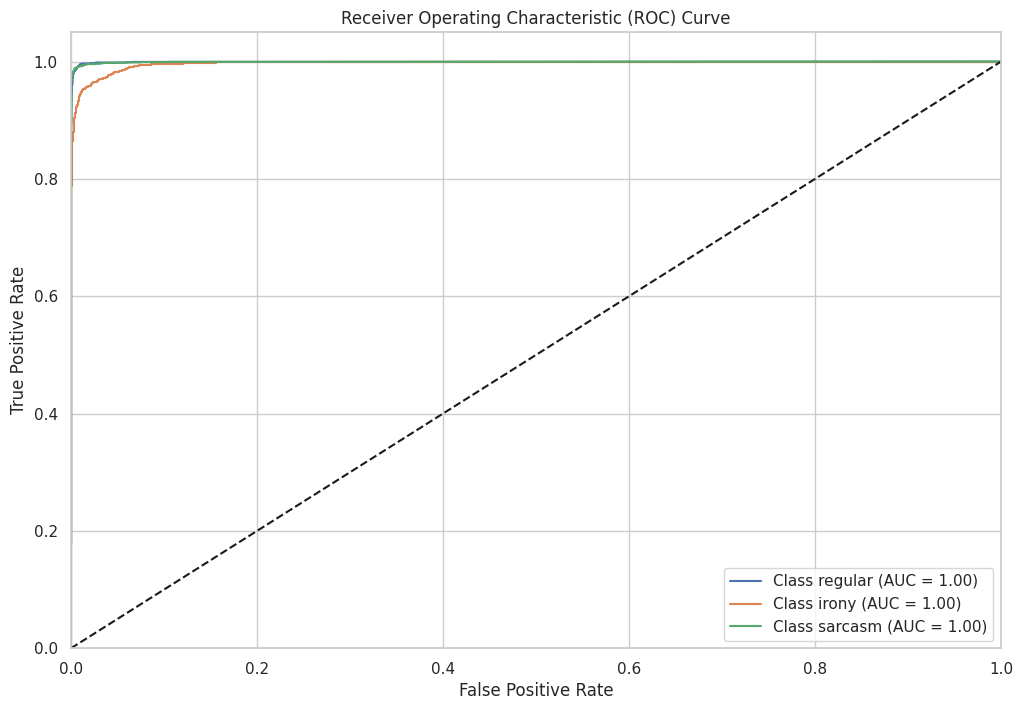

In [ ]:
y_true_bin = label_binarize(y_true, classes=list(class_mapping.values()))
y_score = []

with torch.no_grad():
    for embeddings, labels in test_dataloader:
        embeddings = embeddings.to(device)
        outputs = model(embeddings)
        y_score.append(outputs.cpu().numpy())

y_score = np.concatenate(y_score, axis=0)

roc_auc = {}
for class_label, class_index in class_mapping.items():
    roc_auc[class_label] = roc_auc_score(y_true_bin[:, class_index], y_score[:, class_index])
    print(f'Class {class_label} ROC AUC score: {roc_auc[class_label]:.2f}')

# Plot ROC curve
plt.figure(figsize=(12, 8))
for class_label, class_index in class_mapping.items():
    fpr, tpr, _ = roc_curve(y_true_bin[:, class_index], y_score[:, class_index])
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc[class_label]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
original_texts_test = df_test['tweets'].tolist()
misclassified_samples_test = []

with torch.no_grad():
    for batch_idx, (embeddings, labels) in enumerate(test_dataloader):
        embeddings, labels = embeddings.to(device), labels.to(device)
        outputs = model(embeddings)
        _, preds = torch.max(outputs, dim=1)

        for i in range(len(labels)):
            true_label = labels[i].item()
            predicted_label = preds[i].item()
            if true_label != predicted_label:
                original_index = batch_idx * test_dataloader.batch_size + i
                text = original_texts_test[original_index]
                misclassified_samples_test.append({
                    'text': text,
                    'true_label': reverse_class_mapping[true_label],
                    'predicted_label': reverse_class_mapping[predicted_label]
                })

for sample in misclassified_samples_test:
    print(f"Text: {sample['text']}")
    print(f"True Class: {sample['true_label']}")
    print(f"Predicted Class: {sample['predicted_label']}")
    print("-" * 50)

Text: Just banged my head on my wardrobe whilst doing the migraine skank and it's legit giving me a migraine now.. 😏😏 #Ironic
True Class: irony
Predicted Class: regular
--------------------------------------------------
Text: Checking out Accountancy Age's Top 50 Websites Reviews 2015. All results available for download of course... IN A SPREADSHEET! #irony
True Class: irony
Predicted Class: regular
--------------------------------------------------
Text: Vicki seems obsessed with Meghan's net worth--and yet she's dated 4 years a man who doesn't hold a job or pay his child support #irony #RHOC
True Class: irony
Predicted Class: regular
--------------------------------------------------
Text: Never thought I'd see the day when #humpday and #JoeJackson would be trending topics on Twitter at the same time. #ironic #Viagra
True Class: irony
Predicted Class: regular
--------------------------------------------------
Text: Literally, Donald Trump sounds like he is running for President in 19

In [ ]:
misclassified_df_test = pd.DataFrame(misclassified_samples_test)
misclassified_df_test.to_csv('/content/drive/MyDrive/Классификатор негативных комментариев/misclassified_samples_test.csv', index=False)

Подробный анализ каждой ошибки представлен [здесь](https://docs.google.com/spreadsheets/d/1Ew3r-fprCOXdZ8H2AWVLOFl5S2acGjqFiqn9JAa6ct0/edit?usp=sharing)